Local Outlier Factor Example
Local Outlier Factor (LOF) is a common algorithm for identifying data points that are inliers/outliers relative to their neighbors. The algorithm works by comparing how close an element is to its neighbors vs how close they are to their neighbors. The number of neighbors to use, k, is set by the user. Scores much less than one are inliers, scores much greater are outliers, and those near one are neither.

In [1]:
from sedona.spark import SedonaContext

config = SedonaContext.builder().getOrCreate()
sedona = SedonaContext.create(config)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Data Generation
Random data explicitly designed to be outliers

In [11]:
import numpy as np
import pyspark.sql.functions as f
import geopandas as gpd
from sedona.stats.outlier_detection.local_outlier_factor import local_outlier_factor
from sedona.sql import ST_MakePoint

In [3]:
np.random.seed(42)

In [4]:
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]


df = sedona.createDataFrame(X).select(ST_MakePoint(f.col("_1"), f.col("_2")).alias("geometry"))
outliers_df = local_outlier_factor(df, 20)


outliers_df = local_outlier_factor(df, 20)
The local_outlier_factor(...) function runs the LOF (Local Outlier Factor) algorithm.

This algorithm analyzes the local density of points (i.e. how "lonely" a given point is relative to its neighbors).

The parameter 20 is the number of neighbors (n_neighbors) — the point is evaluated relative to the nearest 20 other points.

In [9]:
df.show(truncate=False)

+---------------------------------------------+
|geometry                                     |
+---------------------------------------------+
|POINT (2.14901424590337 1.9585207096486446)  |
|POINT (2.1943065614302077 2.4569089569224074)|
|POINT (1.9297539875829992 1.929758912915246) |
|POINT (2.4737638446522174 2.230230418745873) |
|POINT (1.8591576842195143 2.1627680130757896)|
|POINT (1.8609746921562613 1.860281073928923) |
|POINT (2.07258868146981 1.4260159266026606)  |
|POINT (1.48252465024609 1.8313137412277083)  |
|POINT (1.6961506638996728 2.094274199778582) |
|POINT (1.7275927773436368 1.5763088895994126)|
|POINT (2.439694630676466 1.9322671098540394) |
|POINT (2.020258461406377 1.572575544135963)  |
|POINT (1.8366851826424453 2.0332767769129596)|
|POINT (1.6547019267733092 2.1127094055037015)|
|POINT (1.8198083930243585 1.912491875062017) |
|POINT (1.8194880163311808 2.555683455352681) |
|POINT (1.9959508325786197 1.68268672131323)  |
|POINT (2.2467634736309567 1.63374690500

In [10]:
outliers_df.show()

+--------------------+------------------+
|            geometry|               lof|
+--------------------+------------------+
|POINT (-1.9169927...|0.9991534865548664|
|POINT (-1.7562422...|1.1370318880088373|
|POINT (-2.0107478...|1.1533763384772193|
|POINT (-2.7859235...|1.9332172688471636|
|POINT (2.55973235...| 1.412366618319909|
|POINT (-2.1801916...| 0.961540637365486|
|POINT (2.07796483...|0.9853622244279292|
|POINT (1.85624772...|0.9589109737671689|
|POINT (1.86097469...|0.9674509993627178|
|POINT (2.02989540...|0.9664263638243167|
|POINT (2.07514785...| 0.985611629172046|
|POINT (1.97686948...|0.9470068256226991|
|POINT (-2.1339544...|0.9942355346832784|
|POINT (2.00390056...|1.1341241188002171|
|POINT (-2.2106159...| 0.978489569891795|
|POINT (-2.0104135...|1.0460664891838962|
|POINT (2.05195427...|0.9690855312096931|
|POINT (2.15658246...| 1.009761012110145|
|POINT (-0.9953363...| 3.932118123876308|
|POINT (-2.0702460...|0.9721267506543889|
+--------------------+------------

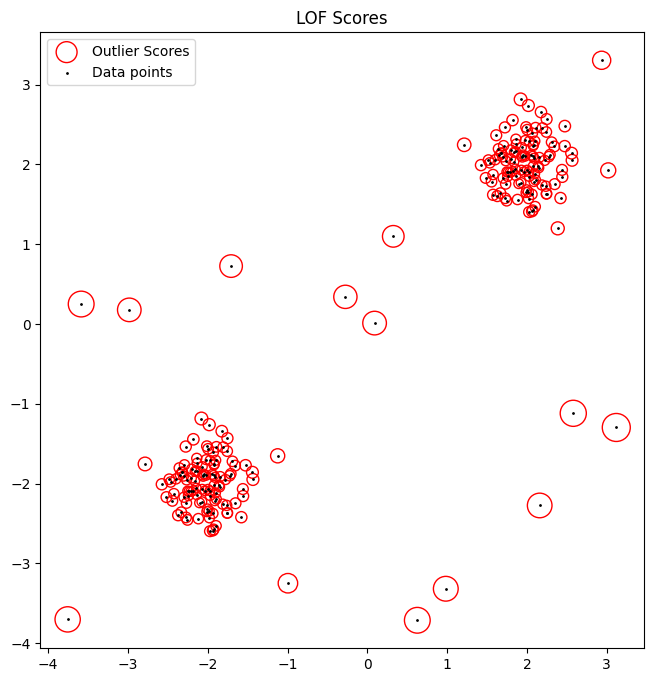

In [12]:
pdf = (outliers_df
       .withColumn("lof", f.col("lof") * 50)
       .toPandas()
      )
gdf = gpd.GeoDataFrame(pdf, geometry="geometry")

ax = gdf.plot(
    figsize=(10, 8),
    markersize=gdf['lof'],
    edgecolor='r',
    facecolors="none",
)

gdf.plot(ax=ax, figsize=(10, 8), color="k", markersize=1, legend=True)

ax.set_title('LOF Scores')
ax.legend(['Outlier Scores', 'Data points'])